# Time Series Classification with Convolutions

How a simple 1d Convolutional Neural Net is able to find time patterns without further feature engineering and achieve impressive results.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from datetime import datetime, timedelta

import torch
from torch import nn
from torch import optim
from torch.nn import functional as F
from torch.optim.lr_scheduler import _LRScheduler
from torch.utils.data import TensorDataset, DataLoader

For this blog, I will use the Italy Power demand dataset. The classification task is to distinguish days from Oct to March (inclusive) from April to September. The dataset can be found here: http://www.timeseriesclassification.com/description.php?Dataset=ItalyPowerDemand. The best accuracy so far is stated by the webpage as 97%.

In [2]:
df_train = pd.read_csv('Data/ItalyPowerDemand_TRAIN.txt', header=None,delim_whitespace=True)
df_test = pd.read_csv('Data/ItalyPowerDemand_TEST.txt', header=None, delim_whitespace=True)

In [3]:
df_train.head()

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
0,1.0,-0.710518,-1.183320,-1.372442,-1.593083,-1.467002,-1.372442,-1.088760,0.045967,0.928532,...,-0.647477,-0.269235,-0.206195,0.613330,1.369815,1.464375,1.054613,0.581810,0.172048,-0.269235
1,1.0,-0.993009,-1.426786,-1.579884,-1.605401,-1.630917,-1.375754,-1.018526,-0.355102,0.716583,...,0.486936,0.563485,0.614518,0.308322,0.257289,1.099327,1.048295,0.691066,-0.048906,-0.380618
2,2.0,1.319067,0.569774,0.195128,-0.085856,-0.179518,-0.273180,-0.085856,-1.397118,-1.116134,...,-0.554164,-0.741487,-0.741487,-0.741487,-1.116134,-0.460503,0.476113,2.349344,2.255682,1.600052
3,2.0,-0.812444,-1.157553,-1.416385,-1.531421,-1.502662,-1.416385,-1.646458,-0.467335,0.654269,...,0.740547,0.884342,0.884342,0.683028,0.625510,0.424197,-0.007190,-0.035949,0.107847,-0.266022
4,1.0,-0.972840,-1.390518,-1.536705,-1.620240,-1.620240,-1.453169,-0.993724,0.050469,0.635218,...,0.321960,0.489031,0.614334,1.303502,1.240850,1.073779,0.551682,0.426379,-0.179253,-0.638698


In [4]:
len(df_train), len(df_test)

(67, 1029)

The first column represents the target, the rest is one feature over the course of 24 days. The task then is to correctly classify, whether this month is in winter or in summer.

In [5]:
x_train = df_train.iloc[:, 1:].values.reshape(-1, 1, 24)
x_test = df_test.iloc[:, 1:].values.reshape(-1, 1, 24)

In [6]:
y_train = df_train.iloc[:, 0].values-1
y_test = df_test.iloc[:, 0].values-1

In [7]:
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((67, 1, 24), (1029, 1, 24), (67,), (1029,))

## Plot some time series

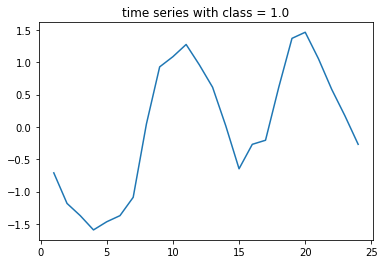

In [160]:
df_train.iloc[0, 1:].plot.line(title=f'time series with class = {df_train.iloc[0, 0]}');

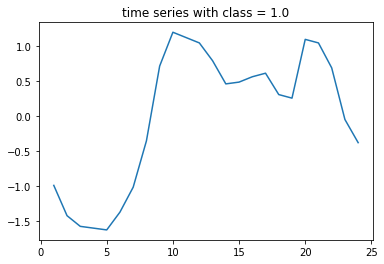

In [161]:
df_train.iloc[1, 1:].plot.line(title=f'time series with class = {df_train.iloc[1, 0]}');

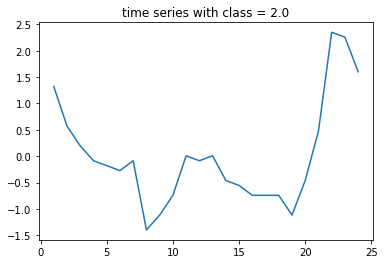

In [162]:
df_train.iloc[2, 1:].plot.line(title=f'time series with class = {df_train.iloc[2, 0]}');

## to dataset and dataloader

In [8]:
def create_datasets(train, test, train_target, test_target, valid_pct=0.1, seed=None):
    """Converts NumPy arrays into PyTorch datsets."""
    
    train, test, train_target, test_target = train, test, train_target, test_target
    assert len(train)==len(train_target)
    idx = np.arange(len(train))
    trn_idx, val_idx = train_test_split(
        idx, test_size=valid_pct, random_state=seed)
    trn_ds = TensorDataset(
        torch.tensor(train[trn_idx]).float(), 
        torch.tensor(train_target[trn_idx]).long())
    val_ds = TensorDataset(
        torch.tensor(train[val_idx]).float(), 
        torch.tensor(train_target[val_idx]).long())
    tst_ds = TensorDataset(
        torch.tensor(test).float(),  
        torch.tensor(test_target).long())
    return trn_ds, val_ds, tst_ds

In [9]:
def create_loaders(data, bs=128, jobs=0):
    """Wraps the datasets returned by create_datasets function with data loaders."""
    
    trn_ds, val_ds, tst_ds = data
    trn_dl = DataLoader(trn_ds, batch_size=bs, shuffle=True, num_workers=jobs)
    val_dl = DataLoader(val_ds, batch_size=bs, shuffle=False, num_workers=jobs)
    tst_dl = DataLoader(tst_ds, batch_size=bs, shuffle=False, num_workers=jobs)
    return trn_dl, val_dl, tst_dl

In [10]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
trn_sz=40
datasets = create_datasets(x_train, x_test, y_train, y_test, seed=1234)
trn_dl, val_dl, tst_dl = create_loaders(datasets, bs=256)

In [11]:
class CostumConv1d(nn.Module):
    """Implementes a 1-d convolution with 'batteries included'.
    
    The module adds (optionally) activation function and dropout layers right after
    a separable convolution layer.
    """
    def __init__(self, ni, no, kernel, stride, pad, drop=None,
                 activ=lambda: nn.ReLU(inplace=True)):
    
        super().__init__()
        assert drop is None or (0.0 < drop < 1.0)
        layers = [nn.Conv1d(ni, no, kernel, stride, pad)]
        if activ:
            layers.append(activ())
        if drop is not None:
            layers.append(nn.Dropout(drop))
        self.layers = nn.Sequential(*layers)
        
    def forward(self, x): 
        return self.layers(x)

In [12]:
class Flatten(nn.Module):
    """Converts N-dimensional tensor into 'flat' one."""

    def __init__(self, keep_batch_dim=True):
        super().__init__()
        self.keep_batch_dim = keep_batch_dim

    def forward(self, x):
        if self.keep_batch_dim:
            return x.view(x.size(0), -1)
        return x.view(-1)

When it comes to Convolutions, we can freely choose the output dimension, however, the length of the newly created tensor after the convolution is pre-defined and calculated as follows:

![alt text](Images/calculation_L.png "from pytorch.org")

After our convolutions we want the L-dimension to be equal to 1, so we can flatten it. We have a sequence of 24. According to the formula we can calculate how the convolution L changes when setting kernel_size, padding and dilation accordingly. Or, we can check it manually:

In [13]:
for epoch in range(1):
    epoch_loss = 0
    for i, batch in enumerate(trn_dl):
        x_raw, y_batch = [t.to(device) for t in batch]
x_raw.shape

torch.Size([60, 1, 24])

If you want to, you can just fiddle around with the numbers. We want to end up at 1 for L in the end. After manually grid searching, I came up with a model where we only use one convolution, with a kernel of the size of the timeframe (at least almost). After that, I apply a max_pooling layer. 

In [143]:
raw_ni=x_train.shape[1] # no of input features (here:1)
drop=0.3
m = CostumConv1d(raw_ni,  32, 23, 1, 0, drop=drop)
output_ = m(x_raw)
print(output_.shape)
# m = CostumConv1d(32,  64, 3, 2, 0, drop=drop)
# output_ = m(output_)
# print(output_.shape)
m = nn.MaxPool1d(2, stride=2)
output_ = m(output_)
print(output_.shape)

torch.Size([5, 32, 2])
torch.Size([5, 32, 1])


And now we know how to set up our model.

In [144]:
class Classifier(nn.Module):
    def __init__(self, raw_ni, no, drop=.5):
        super().__init__()
        
        self.raw = nn.Sequential(
            CostumConv1d(raw_ni,  128, 23, 1, 0, drop=drop),
            # CostumConv1d(    32,  64, 3, 2, 0, drop=drop),
            # CostumConv1d(    64,  256, 3, 1, 0, drop=drop),
            # CostumConv1d(    256,  256, 2, 1, 0, drop=drop),
            # CostumConv1d(    256, 256, 2, 1, 0, drop=drop),
            nn.MaxPool1d(2, stride=2),
            Flatten(),
            nn.Dropout(drop), nn.Linear(128, 64), nn.ReLU(inplace=True),
            nn.Dropout(drop), nn.Linear( 64, 64), nn.ReLU(inplace=True))
        
        self.out = nn.Sequential(
            nn.Linear(64, 64), nn.ReLU(inplace=True), nn.Linear(64, no))
        
    def forward(self, t_raw):
        raw_out = self.raw(t_raw)
        out = self.out(raw_out)
        return out

In [145]:
raw_feat = x_train.shape[1]

lr = 0.001
n_epochs = 500
iterations_per_epoch = len(trn_dl)
num_classes = 2
best_acc = 0
patience, trials = 200, 0
base = 1
step = 2
loss_history = []
acc_history = []

model = Classifier(raw_feat, num_classes).to(device)
criterion = nn.CrossEntropyLoss()
opt = optim.Adam(model.parameters(), lr=lr)

In [146]:
print('Start model training')

for epoch in range(1, n_epochs + 1):
    
    model.train()
    epoch_loss = 0
    for i, batch in enumerate(trn_dl):
        x_raw, y_batch = [t.to(device) for t in batch]
        opt.zero_grad()
        out = model(x_raw)
        loss = criterion(out, y_batch)
        epoch_loss += loss.item()
        loss.backward()
        opt.step()
        
    epoch_loss /= trn_sz
    loss_history.append(epoch_loss)
    
    model.eval()
    correct, total = 0, 0
    for batch in val_dl:
        x_raw, y_batch = [t.to(device) for t in batch]
        out = model(x_raw)
        preds = F.log_softmax(out, dim=1).argmax(dim=1)
        total += y_batch.size(0)
        correct += (preds == y_batch).sum().item()
    
    acc = correct / total
    acc_history.append(acc)

    if epoch % base == 0:
        print(f'Epoch: {epoch:3d}. Loss: {epoch_loss:.4f}. Acc.: {acc:2.2%}')
        base *= step

    if acc > best_acc:
        trials = 0
        best_acc = acc
        torch.save(model.state_dict(), 'best.pth')
        print(f'Epoch {epoch} best model saved with accuracy: {best_acc:2.2%}')
    else:
        trials += 1
        if trials >= patience:
            print(f'Early stopping on epoch {epoch}')
            break
            
print('Done!')

Start model training
Epoch:   1. Loss: 0.0175. Acc.: 57.14%
Epoch 1 best model saved with accuracy: 57.14%
Epoch:   2. Loss: 0.0170. Acc.: 57.14%
Epoch 3 best model saved with accuracy: 100.00%
Epoch:   4. Loss: 0.0172. Acc.: 85.71%
Epoch:   8. Loss: 0.0171. Acc.: 57.14%
Epoch:  16. Loss: 0.0167. Acc.: 71.43%
Epoch:  32. Loss: 0.0132. Acc.: 100.00%
Epoch:  64. Loss: 0.0024. Acc.: 100.00%
Epoch: 128. Loss: 0.0007. Acc.: 100.00%
Early stopping on epoch 203
Done!


In [147]:
def smooth(y, box_pts):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth

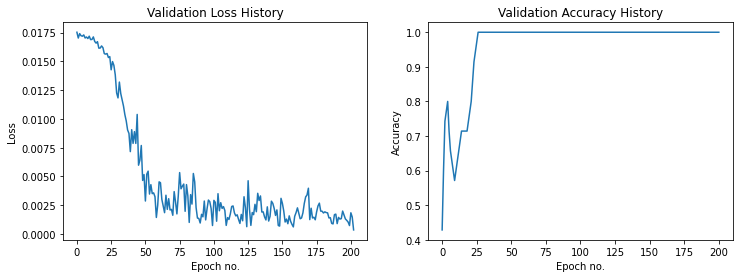

In [148]:
f, ax = plt.subplots(1, 2, figsize=(12, 4))

ax[0].plot(loss_history, label='loss')
ax[0].set_title('Validation Loss History')
ax[0].set_xlabel('Epoch no.')
ax[0].set_ylabel('Loss')

ax[1].plot(smooth(acc_history, 5)[:-2], label='acc')
ax[1].set_title('Validation Accuracy History')
ax[1].set_xlabel('Epoch no.')
ax[1].set_ylabel('Accuracy');

We see that our model did a great job in classifying the validation data correctly. Remember, we only have training data for about 60 cases. Let's see how our model performs on the test dataset.

### Check on test data

In [149]:
preds_array = np.array([])
for batch in tst_dl:
        x_raw, y_batch = [t.to(device) for t in batch]
        out = model(x_raw)
        preds = F.log_softmax(out, dim=1).argmax(dim=1).numpy()
        preds_array = np.concatenate((preds_array, preds), axis=None)

In [150]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, preds_array)

array([[499,  14],
       [ 16, 500]], dtype=int64)

In [151]:
from sklearn.metrics import classification_report
target_names = ['class 1', 'class 2']
print(classification_report(y_test, preds_array, target_names=target_names))

              precision    recall  f1-score   support

     class 1       0.97      0.97      0.97       513
     class 2       0.97      0.97      0.97       516

    accuracy                           0.97      1029
   macro avg       0.97      0.97      0.97      1029
weighted avg       0.97      0.97      0.97      1029



Glorious! We achieved 97% accuracy! That is the current best result for this dataset. Let's have a look at the wrongly classified timeseries.

In [178]:
wrongly_classified_idx = np.argwhere(y_test!=preds_array).reshape(-1)

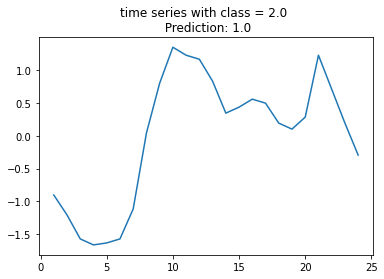

In [179]:
df_test.iloc[wrongly_classified_idx[0], 1:].plot.line(title=f'time series with class = {df_test.iloc[wrongly_classified_idx[0], 0]} \n Prediction: {preds_array[wrongly_classified_idx[0]]+1}');

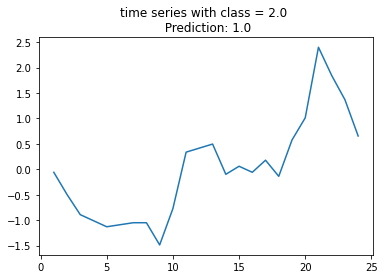

In [180]:
df_test.iloc[wrongly_classified_idx[1], 1:].plot.line(title=f'time series with class = {df_test.iloc[wrongly_classified_idx[1], 0]} \n Prediction: {preds_array[wrongly_classified_idx[1]]+1}');

We can see that these cases are pretty hard to classify correctly. Especially the first case looks almost like a mislabeling.

After this very hands-on approach in the next blog I'll write about the way 1d convolutions work and the math behind it, so stay tuned!
Lasse